In [1]:
# Implementation of "Algorithm for Automatically Fitting Digitized Curves" by Philip J. Schneider from "Graphics Gems", Academic Press, 1990

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CHORD LENGTH PARAMETERISATION
def ChordLengthParameterisaion(points):

    # initialise the length vector
    u = [0.0]

    # add a point to u with distance defined by distance between two consecutive points
    for i in range(1, len(points)):
        u.append(u[i-1] + np.linalg.norm(points[i] - points[i-1]))

    # normalise u by total length to a final range of [0, 1]    
    u = u/u[-1]

    return u

In [3]:
# FINDS THE CUBIC BEZIER FIT AT POSITION t
def CubicBezierCurveValue(ctrlPoly, t):
    
    # evaluates Bernstein's polynomial at point (t)
    b = (1.0-t)**3 * ctrlPoly[0] + 3*(1.0-t)**2 * t * ctrlPoly[1] + 3*(1.0-t)* t**2 * ctrlPoly[2] + t**3 * ctrlPoly[3]
    
    return b

In [4]:
# FINDS THE FIRST DERIVATIVE OF THE BEZIER CURVE AT POSITION t
def CubicBezierFirstDerivative(ctrlPoly, t):

    # evaluates first derivative at point (t)
    b_dev = 3*(1.0-t)**2 * (ctrlPoly[1]-ctrlPoly[0]) + 6*(1.0-t) * t * (ctrlPoly[2]-ctrlPoly[1]) + 3*t**2 * (ctrlPoly[3]-ctrlPoly[2])
    
    return b_dev

In [5]:
# FINDS THE SECOND DERIVATIVE OF THE BEZIER CURVE AT POSITION t
def CubicBezierSecondDerivative(ctrlPoly, t):

    # evaluates first derivative at point (t)
    b_s_dev = 6*(1.0-t) * (ctrlPoly[2]-2*ctrlPoly[1]+ctrlPoly[0]) + 6*(t) * (ctrlPoly[3]-2*ctrlPoly[2]+ctrlPoly[1])
    
    return b_s_dev

In [6]:
def generateBezier_Schneider(VectorPoints, CLP):
    
    # Using the initial tangent estimates to find the control points that minimsies dist = || P - Q(t) || (Eqn 1, pg 617). This requries determining matrices C and X
    # whose determinants allows us to obtain the values of alpha_l and alpha_r which can be used to make an intiial estimate of the placement of the inner control 
    # points of the Bezier curve. 
    #
    # The mathematical derivations for these values are found on pgs 618 - 619 of Graphical Gems
    
    # estimate the left tangent vector
    LT = (VectorPoints[1] - VectorPoints[0])/np.linalg.norm(VectorPoints[1] - VectorPoints[0])

    # estimate the right tangent vector
    RT = (VectorPoints[-2] - VectorPoints[-1])/np.linalg.norm(VectorPoints[-2] - VectorPoints[-1])
    
    # set the initial container of the control points
    ctrlPoly = [VectorPoints[0], None, None, VectorPoints[-1]]

    # compute the A's
    A = np.zeros((len(CLP), 2, 2))
    for i, u in enumerate(CLP):
        A[i][0] = LT * 3 * (1-u)**2 * u
        A[i][1] = RT * 3 * (1-u)    * u**2

    # Create the C and X matrices
    C = np.zeros((2, 2))
    X = np.zeros(2)

    for i, (point, u) in enumerate(zip(VectorPoints, CLP)):
        C[0][0] += np.dot(A[i][0], A[i][0])
        C[0][1] += np.dot(A[i][0], A[i][1])
        C[1][0] += np.dot(A[i][0], A[i][1])
        C[1][1] += np.dot(A[i][1], A[i][1])

        tmp = point - CubicBezierCurveValue([VectorPoints[0], VectorPoints[0], VectorPoints[-1], VectorPoints[-1]], u)

        X[0] += np.dot(A[i][0], tmp)
        X[1] += np.dot(A[i][1], tmp)

    # Compute the determinants of C and X
    det_C0_C1 = C[0][0] * C[1][1] - C[1][0] * C[0][1]
    det_C0_X  = C[0][0] * X[1] - C[1][0] * X[0]
    det_X_C1  = X[0] * C[1][1] - X[1] * C[0][1]

    # Derive alpha values
    alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
    alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

    # If any of the alpha_l or alpha_r is a negative value, or 0, subsequent Newton Raphosn optimisation will result in divide by zeros. In such cases, the heuristic
    # placement of the intermediate control points i.e. placing them at the 1/3 points will be adopted. 
    
    dist = np.linalg.norm(VectorPoints[0] - VectorPoints[-1])/3.0
    
    epsilon = 1.0e-6 * dist
    
    if alpha_l < epsilon or alpha_r < epsilon:
        print('using heuristic')
        # using the 1/3 placement heuristing
        ctrlPoly[1] = ctrlPoly[0] + LT * dist
        ctrlPoly[2] = ctrlPoly[3] + RT * dist

    else:
        # using alpha_1 and alpha_2 to place the intermediate control points
        ctrlPoly[1] = ctrlPoly[0] + LT * alpha_l
        ctrlPoly[2] = ctrlPoly[3] + RT * alpha_r
    
    ctrlPoly = np.asarray(ctrlPoly)
    
    return ctrlPoly

In [7]:
def generateBezier_Heuristic(VectorPoints):
    
    # Finds a heurisitc estimation of the control points using the 1/3 divisions of the curve length as placement positions for intermediary points

    # estimate the left tangent vector
    LT = (VectorPoints[1] - VectorPoints[0])/np.linalg.norm(VectorPoints[1] - VectorPoints[0])

    # estimate the right tangent vector
    RT = (VectorPoints[-2] - VectorPoints[-1])/np.linalg.norm(VectorPoints[-2] - VectorPoints[-1])

    # find the point which is at the 1/3 point of the length of the curve
    dist = np.linalg.norm(VectorPoints[0] - VectorPoints[-1])/3.0

    # set the intermediary control points
    ctrlPoly = np.asarray([VectorPoints[0], VectorPoints[0] + LT*dist, VectorPoints[-1] + RT*dist, VectorPoints[-1]])
    
    return ctrlPoly

In [8]:
def NewtonRaphsonRootFinder(ctrlPoly, VectorPoints, u):
    
    
    # difference between cubic bezier fit and acutal vector points
    d = CubicBezierCurveValue(ctrlPoly, u) - VectorPoints
    
    # first derivative at u
    b1 = CubicBezierFirstDerivative(ctrlPoly, u)
    
    # second derivative at u
    b2 = CubicBezierSecondDerivative(ctrlPoly, u)
    
    
    numerator = (d * b1).sum()
    denominator = (b1**2 + d * b2).sum()

    if denominator == 0.0:
        return u
    else:
        return u - numerator/denominator

In [9]:
# SET SOME CONTROL POINTS FOR COMPARISON PURPOSES - TO USE AS GROUND TRUTH

ctrlPolyTrue = np.array([[0, 0],[6, 4], [6, 8], [0, 16]])

# CREATE THE BEZIER CURVE TO FIT THESE CONTROL POINTS

# initalise the curve array
VectorPoints = np.zeros((101, 2))

# loop through all points along the curve
for n in range(0, 101, 1):
    
    t = n/100
    
    # Bernstein's polynomial at point (t)
    VectorPoints[n, :] = CubicBezierCurveValue(ctrlPolyTrue, t)   

In [10]:
# FITS BEZIER CURVES USING THE HEURISTIC AND SCHNEIDER'S METHOD FOR COMPARISON

# Find control points using heurisitc method
ctrlPoly_HE = generateBezier_Heuristic(VectorPoints)


# Find control points using Schneider's method
CLP = ChordLengthParameterisaion(VectorPoints) # chord length parameterisation 
ctrlPoly_SE = generateBezier_Schneider(VectorPoints, CLP) # control point estimation

# Apply Newton-Raphson Optimisation
CLP_Prime = [NewtonRaphsonRootFinder(ctrlPoly_SE, point, u) for point, u in zip(VectorPoints, CLP)]
ctrlPoly_SE_NR = generateBezier_Schneider(VectorPoints, CLP_Prime) 

# Generate the Bezier curves

Points_HE = np.zeros((101, 2)) # initalise the curve array
Points_SE = np.zeros((101, 2)) # initalise the curve array
Points_SE_NR = np.zeros((101, 2)) # initalise the curve array

# loop through all points along the curve
for n in range(0, 101, 1):
    
    t = n/100
    
    # Bernstein's polynomial at point (t)
    Points_HE[n, :] = CubicBezierCurveValue(ctrlPoly_HE, t)
    Points_SE[n, :] = CubicBezierCurveValue(ctrlPoly_SE, t)
    Points_SE_NR[n, :] = CubicBezierCurveValue(ctrlPoly_SE_NR, t)

Text(0.5, 0.98, 'Schneider with Newton-Raphson (red = ground-truth)')

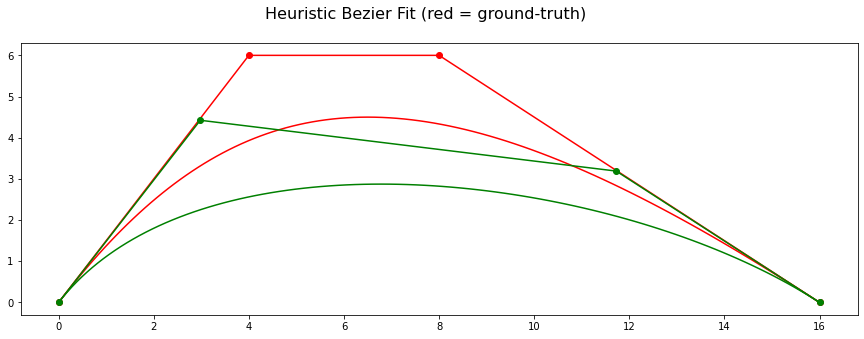

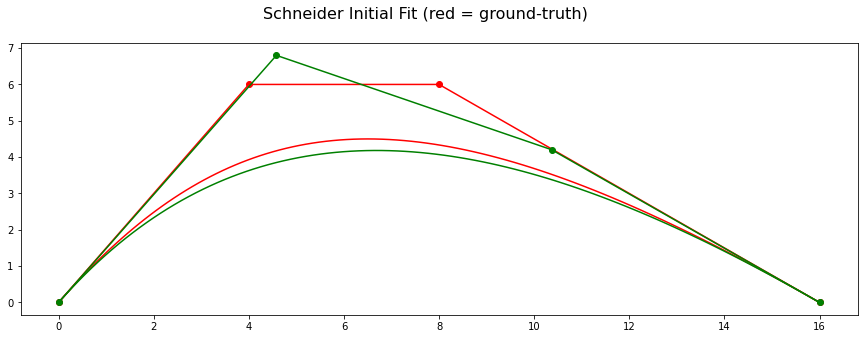

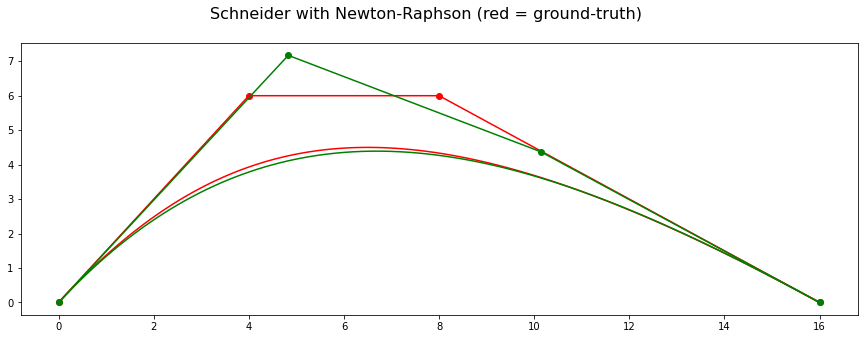

In [11]:
# PLOT THE CONTROL POLYGON AND THE BEZIER FIT

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

plt.plot(ctrlPolyTrue[:, 1], ctrlPolyTrue[:, 0], 'r-o')
plt.plot(VectorPoints[:, 1], VectorPoints[:, 0], 'r-')

plt.plot(ctrlPoly_HE[:, 1], ctrlPoly_HE[:, 0], 'g-o')
plt.plot(Points_HE[:, 1], Points_HE[:, 0], 'g-')

fig.suptitle('Heuristic Bezier Fit (red = ground-truth)', fontsize=16)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

plt.plot(ctrlPolyTrue[:, 1], ctrlPolyTrue[:, 0], 'r-o')
plt.plot(VectorPoints[:, 1], VectorPoints[:, 0], 'r-')

plt.plot(ctrlPoly_SE[:, 1], ctrlPoly_SE[:, 0], 'g-o')
plt.plot(Points_SE[:, 1], Points_SE[:, 0], 'g-')

fig.suptitle('Schneider Initial Fit (red = ground-truth)', fontsize=16)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

plt.plot(ctrlPolyTrue[:, 1], ctrlPolyTrue[:, 0], 'r-o')
plt.plot(VectorPoints[:, 1], VectorPoints[:, 0], 'r-')

plt.plot(ctrlPoly_SE_NR[:, 1], ctrlPoly_SE_NR[:, 0], 'g-o')
plt.plot(Points_SE_NR[:, 1], Points_SE_NR[:, 0], 'g-')

fig.suptitle('Schneider with Newton-Raphson (red = ground-truth)', fontsize=16)